# CSCE5210: Introduction to AI
### Name: Rubayet Kabir Tonmoy, ID: 11800754
### Name: Jayed Mohammad Barek, ID:11814532

# Building the Graph

In [ ]:
import networkx as nx # create an empty graph
G=nx.Graph()

In [ ]:
# create example graph for R2 with weights on edges, weight 1 means toll road to distinguish from non toll roads with weight 0
G.add_edges_from([(3, 9, {'weight': 2}),(1, 4, {'weight': 1}), (1, 9,{'weight': 1}), (4,9,{'weight': 1}), (9,2, {'weight': 1}), (9,7, {'weight': 1}), (2,7, {'weight': 1}),  (2,5, {'weight': 2}),  (7,5, {'weight': 1}),  (7,8,{'weight': 2}), (5,6, {'weight': 1}), (5,8, {'weight': 1}), (5,10, {'weight': 2}),(8,6, {'weight': 2}),(8,10, {'weight': 1})])

In [ ]:
print(G)

Graph with 10 nodes and 15 edges


In [ ]:
nx.is_connected(G)

True

node degree
3 1
9 5
1 2
4 2
2 3
7 4
5 5
8 4
6 2
10 2

the adjacency list
3 9
9 1 4 2 7
1 4
4
2 7 5
7 5 8
5 6 8 10
8 6 10
6
10
{(3, 9): 2, (9, 1): 1, (9, 4): 1, (9, 2): 1, (9, 7): 1, (1, 4): 1, (2, 7): 1, (2, 5): 2, (7, 5): 1, (7, 8): 2, (5, 6): 1, (5, 8): 1, (5, 10): 2, (8, 6): 2, (8, 10): 1}


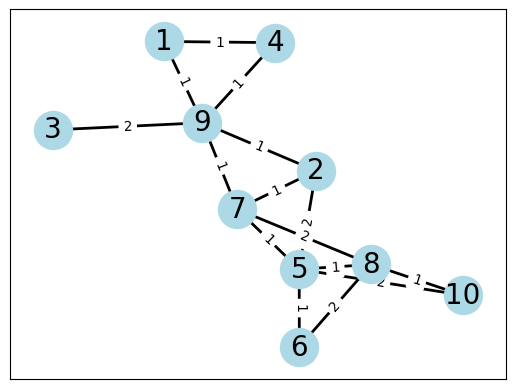

In [ ]:
import matplotlib.pyplot as plt # routine to plot the example graph

# some properties
print("node degree")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)}")

print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', linewidths=0.05) # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=2)                               # draw edges

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G, 'weight','trips')
print(edge_labels)
#print("%.2f" % edge_labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

# R2 Code
## Customer and Van Class, Their attributes and methods

In [ ]:
# Customer Class
class Customer:
  def __init__(self, customer_id):
    self.customer_id = customer_id
    self.pickup_node = random.randint(1,10)
    self.dropoff_node = random.randint(1,10)
    # Making sure that the pickup and dropoff nodes are different using {while loop}, until not different node
    while self.pickup_node == self.dropoff_node:
        self.dropoff_node = random.randint(1,10)

# Van Class
class Van:
  def __init__(self,van_id):
    self.van_id = van_id
    self.current_node = 1
    self.idle = True
    self.service_queue = []
    self.p_traversed_nodes = []
    self.inside_van_service_queue = []
    self.congested_node_flag = False
    self.customer_serviced = 0
    self.number_of_nodes_visited = 0

  def move_one_step(self,destination_node):
    # Using shortest path from networkx and avoid congested path
    path = nx.dijkstra_path(G,self.current_node,destination_node, weight='weight')
    next_node = nx.shortest_path(G, self.current_node, destination_node, weight='weight')[1]
    print("van{} route:{}".format(self.van_id,path))
    print("van{} next travel node:{}".format(self.van_id,next_node))
    return next_node

  def update_node(self,destination_node):
    if destination_node is None or not G.has_node(destination_node):
        print(f"Error: Node {destination_node} not found in the graph.")
    if self.current_node != destination_node:
        next_node = nx.shortest_path(G, self.current_node, destination_node, weight='weight')[1] # checking next node
        # checking if we are forced to traverse a congested node
        if G.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == False:
          self.congested_node_flag = True # set flag for congested node
          print("van{} is treaversing congested node:{}".format(self.van_id,next_node))
        elif G.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == True:
          self.congested_node_flag == False # we've traveled one clock tick on congested node, setting flag to false
          self.current_node = self.move_one_step(destination_node)
          # keep note of number of nodes visited by this van
          self.number_of_nodes_visited += 1
        else:
          self.current_node = self.move_one_step(destination_node)
          self.number_of_nodes_visited += 1
    print(f"Van{self.van_id} moved to {self.current_node}")
    print("Van{} service queue:{}".format(self.van_id,self.service_queue))
    print("Van{} has {} passengers, their(id,pickup,dropoff):{}".format(self.van_id,len(self.inside_van_service_queue),self.inside_van_service_queue))


  def idle_status(self):
    if self.service_queue == []:
        self.idle = True
        print("Van{} is parked at {}".format(self.van_id, self.current_node))
    else:
        self.idle = False

  def dropoff_customer(self):
    if self.service_queue != []:
        # for drop off we use the inside van service list(customers in the van)
        for request in self.inside_van_service_queue:
            customer_id,_,dropoff_node = request
            # permisible pick up nodes along the route
            permisible_pickup_nodes = nx.dijkstra_path(G,self.current_node,dropoff_node, weight='weight')[1:-2] # next node to before drop off
            # Dropping off customers at the dropoff node if their drop off node is same
            if self.current_node == dropoff_node:
                print(f"Van{self.van_id} dropped off customer {customer_id} at {dropoff_node}")
                # Remove the request from van's service queue and inside van service queue after dropoff
                self.service_queue = [service_request for service_request in self.service_queue if service_request[2] != dropoff_node]
                self.inside_van_service_queue = [service_request for service_request in self.inside_van_service_queue if service_request[2] != dropoff_node]
                self.customer_serviced += 1
                # we need to get rid off pick up node already traversed related to this drop off node
                del self.p_traversed_nodes[0]
                break
            elif self.current_node in permisible_pickup_nodes: # we'll pick up customers in service queue if they are along a drop off path
              for request in self.service_queue:
                if request[1] == self.current_node:
                  print("van{} picked up customer{} from: {}".format(self.van_id,request[0],self.current_node))
                  self.inside_van_service_queue.append(request) # add customers in inside service queue
                  self.update_node() # move van one node afer pick up
            else:
              self.update_node(dropoff_node)
              break

  def pickup_customer(self):
    if self.service_queue != []:
        for request in self.service_queue:
            customer_id,pickup_node,_ = request
            if self.current_node == pickup_node and len(self.inside_van_service_queue)<6:
                # Picking up customers at the pickup node if their pickup node is same
                print(f"Van{self.van_id} picked up customer {customer_id} from {pickup_node}")
                # updating passengers inside the van
                self.inside_van_service_queue.append(request)
                # We need to flag current pickup node as already traversed
                self.p_traversed_nodes.append(pickup_node)
                self.dropoff_customer()
                break
            elif self.current_node == pickup_node and len(self.inside_van_service_queue)==5:   # If van is full with 5 passengers
              print("van{} is full customer{} has to wait 15 mins!".format(self.van_id,customer_id))
              self.update_node(pickup_node)
              break
            elif pickup_node in self.p_traversed_nodes:
                self.dropoff_customer()
                break
            else:
              self.update_node(pickup_node)
              break

## Method to assign the generated customer service request

In [ ]:
def assign_request(customer_id,pickup_node,dropoff_node,vans):
    min_distance = float('inf')  # Giving min_distance an initial value of infinity to later assign smaller values
    selected_van = None

    for van in vans:
        # Get the shortest distance from the van's current node to the pickup node
        distance = nx.dijkstra_path(G, van.current_node, pickup_node)

        # Select the van with the shortest distance or the lowest van_id in case of tie in distance from pickup node
        if float(len(distance)) < min_distance:
            min_distance = float(len(distance))
            selected_van = van
        elif float(len(distance)) == min_distance and van.van_id < selected_van.van_id:
            selected_van = van

    selected_van.service_queue.append((customer_id,pickup_node,dropoff_node))
    print(f"Assigned customer {customer_id} (Pickup: {pickup_node}, Dropoff: {dropoff_node}) to Van {selected_van.van_id}")

# Taxi Service Simulation


## R2 Simulation

In [ ]:
import random
import time
from datetime import datetime, timedelta

# Service Start and End Times
service_start_time = datetime.strptime('08:00', '%H:%M')
service_end_time = datetime.strptime('18:00', '%H:%M')
current_time = service_start_time
clock_tick = timedelta(minutes=1)
clock_tick_counter = 1
stop_service = 0

customer_request_list = []  # This list will contain customer requests that will be generated at each clock tick
next_id = 1 # Next Customer ID


# We have 2 vans
vans = [Van(van_id=i) for i in range(1, 3)]

# Method to check if every van's service queue is empty
def every_van_ended_service(VansList):
  for every_van in VansList:
    if every_van.service_queue != []:
      return False
    else:
      return True

# Function to generate customer requests at each clock tick
def generate_customer_requests(customer_request_list,current_time,next_id):
    customer = Customer(next_id)
    customer_request_list.append(customer)  # Add customer request to the list
    print(f"New pick up request from customer {customer.customer_id} (Pickup: {customer.pickup_node}, Dropoff: {customer.dropoff_node}) at {current_time.strftime('%H:%M')}")
    return next_id + 1

# ---------------Simulation Starts Here--------------------

while stop_service<1:
  # Simulation loop from Service Start to End Time
  if current_time <= service_end_time:
      # Generate customer requests
      iteration_number = random.randint(1,4)
      for i in range(iteration_number):
        next_id = generate_customer_requests(customer_request_list,current_time,next_id)

  # Assign customer requests to vans
  for customer in customer_request_list[:]:
      assign_request(customer.customer_id, customer.pickup_node,customer.dropoff_node,vans)
      # Once assigned remove the request from the customer request list
      customer_request_list.remove(customer)

  # If van has non empty service queue, it starts to work
  for van in vans:
    if van.service_queue != []:
      van.pickup_customer()
      # van.dropoff_customer() ----> we do not need to run this as our drop off is handeled by the pickup_customer()
      # print("Van {} Service Queue:{}".format(van.van_id,van.service_queue))
    elif every_van_ended_service(vans):
      stop_service += 1
      break
    else:
      van.idle_status()

  print("\n") # space for next clock tick simulation
  print("===================================== Clock Tick:{}".format(clock_tick_counter)) # seperation for next clock tick simulation

  # Move time forward by 1 clock tick
  current_time += clock_tick
  clock_tick_counter += 1

# get the number of customer serviced the whole day
def service_calculation():
  total_count = 0
  total_visited_nodes = 0
  for van in vans:
    total_count += van.customer_serviced
    total_visited_nodes += van.number_of_nodes_visited
  return total_count, total_visited_nodes

total_service_count,visited_node_count = service_calculation()
print("\n")
print("Todal total customer service count was:{} persons.".format(total_service_count))
print("Average customer serviced per hour was:{} persons.".format(total_service_count//10))
print("Average customer waiting time was {} minutes.".format(visited_node_count/total_service_count))

Streaming output truncated to the last 5000 lines.
===================================== Clock Tick:330
New pick up request from customer 829 (Pickup: 4, Dropoff: 8) at 13:30
New pick up request from customer 830 (Pickup: 2, Dropoff: 1) at 13:30
New pick up request from customer 831 (Pickup: 10, Dropoff: 8) at 13:30
New pick up request from customer 832 (Pickup: 2, Dropoff: 4) at 13:30
Assigned customer 829 (Pickup: 4, Dropoff: 8) to Van 1
Assigned customer 830 (Pickup: 2, Dropoff: 1) to Van 1
Assigned customer 831 (Pickup: 10, Dropoff: 8) to Van 2
Assigned customer 832 (Pickup: 2, Dropoff: 4) to Van 1
Van1 dropped off customer 709 at 7
Van2 picked up customer 736 from 10
van2 route:[10, 8, 7, 9, 1]
van2 next travel node:8
Van2 moved to 8
Van2 service queue:[(736, 10, 1), (738, 10, 5), (741, 5, 10), (749, 8, 10), (754, 7, 10), (758, 8, 1), (762, 9, 3), (764, 9, 10), (767, 7, 8), (768, 8, 5), (771, 9, 1), (773, 4, 9), (784, 10, 1), (791, 10, 1), (794, 5, 10), (798, 9, 6), (799, 9, 5), (

## R3 Code

### Build new graph with 100 nodes for R3

In [ ]:
import networkx as nx     # generic graph for R3 onwards
seed=1000          # seed the graph for reproducibility
G2 = nx.gnp_random_graph (100, .06)       # here we create a random binomial graph with 100 nodes and an average (expected) connectivity of 100*.06= 6.

In [ ]:
nx.is_connected(G2)

True

In [ ]:
# randomly allocate congested roads into the network through a binomial process
# with a probability of 0.3; congested roads are assigned a weight of 2 while
# non congested roads have a weight of 1
import random
glist=[]
for u,v in G2.edges:
  glist.append((u,v))
random.shuffle(glist)
weight=1
count=0
for u, v in glist:
  if(count<len(G2.edges)*0.3):
    G2.add_edge(u, v, weight=2)
  else:
    G2.add_edge(u, v, weight=1)
  count+=1
edge_labels = nx.get_edge_attributes(G2, 'weight')

0 14 19 34 42 44 53 54 67 72 81 83 92
1 7 8 15 19 25 28 43 52 85
2 11 26 27 69
3 28 45 74 80
4 23 39 45 46
5 42 52 55 77 79
6 21 66 87 96
7 29 32 68
8 14 17 22 45 51 55 59 72
9 11 13 23 53 73
10 18 27 31 37 91
11 15 19 24 30 63 77 92
12 13 22 40 78
13 61 63 70
14 38 40 42 49 84
15 19 28 56 66 94
16 38 41 81 98
17 44 47 57
18 29 39 57 59 89
19 35 51 86 96 97
20 24 30 32 66 87
21 25 26 34 37 57 69 91
22 32 35 52 91
23 41 58 66 69 83
24 38 40 62 64 68 91 96
25 47 57 60 84 98
26 85 87
27 28 30 31 32 55 77 85 94
28 42 63 65 70 81
29 51 63
30 36 47 59 64 83 86
31 40 44 56 64 66 72
32 38 41 55 58 69 88 91
33 41 55 69 83 86 90 95
34 50 53 76 80
35 46 62
36 37 39 40 45 57 74
37 48 58 77 89 97
38 51 54 98
39 45 66 73 75 92
40 45 55 85
41 68 75 88
42 65 82 89
43 59 64 67 70 94
44 46 52 56 65 75 85
45 85 92 95
46 47 48 60 64 72 79 89
47 80 97 98
48 72 80 93
49 94
50 55 60 69 91 95
51 66 71 84 91
52
53 72 98
54 58 60 70 80 87
55 58 74
56 85 88
57 62 69
58 78
59 71 74 85
60 85 97
61
62 65
63 87 93
6

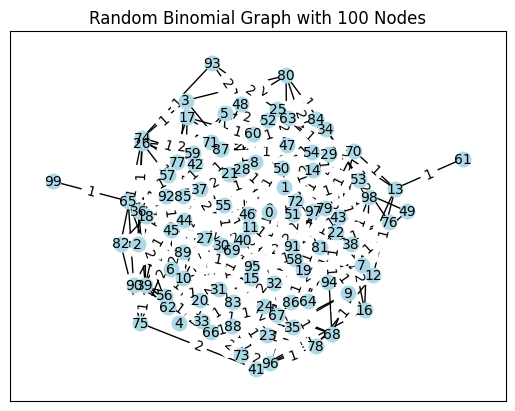

In [ ]:
import matplotlib.pyplot as plt # routine to plot the example graph
for line in nx.generate_adjlist(G2):
    print(line)

links = [(u, v) for (u, v, d) in G2.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G2)
nx.draw_networkx_nodes(G2, pos, node_size=130, node_color='lightblue', linewidths=0.05) # draw nodes
nx.draw_networkx_edges(G2, pos, edgelist=links, width=1)                               # draw edges

# node labels
nx.draw_networkx_labels(G2, pos, font_size=10, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G2, 'weight','trips')
print(edge_labels)
#print("%.2f" % edge_labels)
nx.draw_networkx_edge_labels(G2, pos, edge_labels)
plt.title("Random Binomial Graph with 100 Nodes")
plt.show()

In [ ]:
# Customer Class
class Customer:
  def __init__(self, customer_id):
    self.customer_id = customer_id
    self.pickup_node = random.randint(1,99)
    self.dropoff_node = random.randint(1,99)
    # Making sure that the pickup and dropoff nodes are different using {while loop}, until not different node
    while self.pickup_node == self.dropoff_node:
        self.dropoff_node = random.randint(1,99)

# Van Class
class Van:
  def __init__(self,van_id):
    self.van_id = van_id
    self.current_node = 1
    self.idle = True
    self.service_queue = []
    self.p_traversed_nodes = []
    self.inside_van_service_queue = []
    self.congested_node_flag = False
    self.customer_serviced = 0
    self.number_of_nodes_visited = 0

  def move_one_step(self,destination_node):
    # Using shortest path from networkx and avoid congested path
    path = nx.dijkstra_path(G2,self.current_node,destination_node, weight='weight')
    next_node = nx.shortest_path(G2, self.current_node, destination_node, weight='weight')[1]
    print("van{} route:{}".format(self.van_id,path))
    print("van{} next travel node:{}".format(self.van_id,next_node))
    return next_node

  def update_node(self,destination_node):
    if destination_node is None or not G2.has_node(destination_node):
        print(f"Error: Node {destination_node} not found in the graph.")
        return
    if self.current_node != destination_node:
        next_node = nx.shortest_path(G2, self.current_node, destination_node, weight='weight')[1] # checking next node
        # checking if we are forced to traverse a congested node
        if G2.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == False:
          self.congested_node_flag = True # set flag for congested node
          print("van{} is treaversing congested node:{}".format(self.van_id,next_node))
        elif G2.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == True:
          self.congested_node_flag == False # we've traveled one clock tick on congested node, setting flag to false
          self.current_node = self.move_one_step(destination_node)
          # keep note of number of nodes visited by this van
          self.number_of_nodes_visited += 1
        else:
          self.current_node = self.move_one_step(destination_node)
          self.number_of_nodes_visited += 1
    print(f"Van{self.van_id} moved to {self.current_node}")
    print("Van{} service queue:{}".format(self.van_id,self.service_queue))
    print("Van{} has {} passengers, their(id,pickup,dropoff):{}".format(self.van_id,len(self.inside_van_service_queue),self.inside_van_service_queue))


  def idle_status(self):
    if self.service_queue == []:
        self.idle = True
        print("Van{} is parked at {}".format(self.van_id, self.current_node))
    else:
        self.idle = False

  def dropoff_customer(self):
    if self.service_queue != []:
        # for drop off we use the inside van service list(customers in the van)
        for request in self.inside_van_service_queue:
            customer_id,_,dropoff_node = request
            # permisible pick up nodes along the route
            permisible_pickup_nodes = nx.dijkstra_path(G2,self.current_node,dropoff_node, weight='weight')[1:-2] # next node to before drop off
            # Dropping off customers at the dropoff node if their drop off node is same
            if self.current_node == dropoff_node:
                print(f"Van{self.van_id} dropped off customer {customer_id} at {dropoff_node}")
                # Remove the request from van's service queue and inside van service queue after dropoff
                self.service_queue = [service_request for service_request in self.service_queue if service_request[2] != dropoff_node]
                self.inside_van_service_queue = [service_request for service_request in self.inside_van_service_queue if service_request[2] != dropoff_node]
                self.customer_serviced += 1
                # we need to get rid off pick up node already traversed related to this drop off node
                del self.p_traversed_nodes[0]
                break
            elif self.current_node in permisible_pickup_nodes: # we'll pick up customers in service queue if they are along a drop off path
              for request in self.service_queue:
                if request[1] == self.current_node:
                  print("van{} picked up customer{} from: {}".format(self.van_id,request[0],self.current_node))
                  self.inside_van_service_queue.append(request) # add customers in inside service queue
                  self.update_node() # move van one node afer pick up
            else:
              self.update_node(dropoff_node)
              break

  def pickup_customer(self):
    if self.service_queue != []:
        for request in self.service_queue:
            customer_id,pickup_node,_ = request
            if self.current_node == pickup_node and len(self.inside_van_service_queue)<6:
                # Picking up customers at the pickup node if their pickup node is same
                print(f"Van{self.van_id} picked up customer {customer_id} from {pickup_node}")
                # updating passengers inside the van
                self.inside_van_service_queue.append(request)
                # We need to flag current pickup node as already traversed
                self.p_traversed_nodes.append(pickup_node)
                self.dropoff_customer()
                break
            elif self.current_node == pickup_node and len(self.inside_van_service_queue)==5:   # If van is full with 5 passengers
              print("van{} is full customer{} has to wait 15 mins!".format(self.van_id,customer_id))
              self.update_node(pickup_node)
              break
            elif pickup_node in self.p_traversed_nodes:
                self.dropoff_customer()
                break
            else:
              self.update_node(pickup_node)
              break

In [ ]:
def assign_request(customer_id,pickup_node,dropoff_node,vans):
    min_distance = float('inf')  # Giving min_distance an initial value of infinity to later assign smaller values
    selected_van = None

    for van in vans:
        # Get the shortest distance from the van's current node to the pickup node
        distance = nx.dijkstra_path(G2, van.current_node, pickup_node)

        # Select the van with the shortest distance or the lowest van_id in case of tie in distance from pickup node
        if float(len(distance)) < min_distance:
            min_distance = float(len(distance))
            selected_van = van
        elif float(len(distance)) == min_distance and van.van_id < selected_van.van_id:
            selected_van = van

    selected_van.service_queue.append((customer_id,pickup_node,dropoff_node))
    print(f"Assigned customer {customer_id} (Pickup: {pickup_node}, Dropoff: {dropoff_node}) to Van {selected_van.van_id}")

In [ ]:
import random
import time
from datetime import datetime, timedelta

# Service Start and End Times
service_start_time = datetime.strptime('08:00', '%H:%M')
service_end_time = datetime.strptime('18:00', '%H:%M')
current_time = service_start_time
clock_tick = timedelta(minutes=1)
clock_tick_counter = 1
stop_service = 0

customer_request_list = []  # This list will contain customer requests that will be generated at each clock tick
next_id = 1 # Next Customer ID


# We have 2 vans
vans = [Van(van_id=i) for i in range(1, 31)]

# Method to check if every van's service queue is empty
def every_van_ended_service(VansList):
  for every_van in VansList:
    if every_van.service_queue != []:
      return False
    else:
      return True

# Function to generate customer requests at each clock tick
def generate_customer_requests(customer_request_list,current_time,next_id):
    customer = Customer(next_id)
    customer_request_list.append(customer)  # Add customer request to the list
    print(f"New pick up request from customer {customer.customer_id} (Pickup: {customer.pickup_node}, Dropoff: {customer.dropoff_node}) at {current_time.strftime('%H:%M')}")
    return next_id + 1

# ---------------Simulation Starts Here--------------------

while stop_service<1:
  # Simulation loop from Service Start to End Time
  if current_time <= service_end_time:
      # Generate 450 to 600 customer requests per hour
      # Create a list of clock values that are multiples of 60 between 1 and 601(to generate 45 to 60 request per hour)
      clock_tick_values = list(range(1, 601, 3))
      # Select 10 random clock values from the list
      random_clock_tick_values = random.sample(clock_tick_values, 200)
      if clock_tick_counter in random_clock_tick_values:
        iteration_number = random.randint(20,30)
        for i in range(iteration_number):
          next_id = generate_customer_requests(customer_request_list,current_time,next_id)
      else:
        pass

  # Assign customer requests to vans
  for customer in customer_request_list:
      assign_request(customer.customer_id, customer.pickup_node,customer.dropoff_node,vans)
      # Once assigned remove the request from the customer request list
      customer_request_list.remove(customer)

  # If van has non empty service queue, it starts to work
  for van in vans:
    if van.service_queue != []:
      van.pickup_customer()
      # van.dropoff_customer() ----> we do not need to run this as our drop off is handeled by the pickup_customer()
      # print("Van {} Service Queue:{}".format(van.van_id,van.service_queue))
    elif every_van_ended_service(vans) and current_time > service_end_time:
      stop_service += 1
      break
    else:
      van.idle_status()

  print("\n") # space for next clock tick simulation
  print("===================================== Clock Tick:{}".format(clock_tick_counter)) # seperation for next clock tick simulation

  # Move time forward by 1 clock tick
  current_time += clock_tick
  clock_tick_counter += 1

# get the number of customer serviced the whole day
def service_calculation():
  total_count = 0
  total_visited_nodes = 0
  for van in vans:
    total_count += van.customer_serviced
    total_visited_nodes += van.number_of_nodes_visited
  return total_count, total_visited_nodes

total_service_count,visited_node_count = service_calculation()
print("\n")
print("Todal total customer service count was:{} persons.".format(total_service_count))
print("Average customer serviced per hour was:{} persons.".format(total_service_count//10))
print("Average customer waiting time was {} minutes.".format(visited_node_count/total_service_count))

Streaming output truncated to the last 5000 lines.
Van7 is parked at 89
Van8 is parked at 32
Van9 is parked at 45
Van10 is parked at 49
Van11 is parked at 48
Van12 is parked at 85
Van13 is parked at 7
Van14 is parked at 24
Van15 is parked at 62
Van16 is parked at 93
Van17 is parked at 59
Van18 is parked at 26
Van19 is parked at 41
Van20 is parked at 94
Van21 is parked at 44
Van22 is parked at 28
Van23 is parked at 76
Van24 is parked at 74
Van25 is parked at 22
Van26 is parked at 61
Van27 is parked at 98
Van28 is parked at 79
Van29 is parked at 49
Van30 is parked at 47


===================================== Clock Tick:973
van1 route:[8, 45]
van1 next travel node:45
Van1 moved to 45
Van1 service queue:[(3754, 32, 45), (3756, 40, 55), (3760, 74, 45), (3771, 59, 55), (3789, 86, 98), (3820, 42, 4), (3872, 44, 92), (3878, 42, 52), (3883, 35, 52), (3896, 5, 85), (4068, 71, 20), (4095, 33, 45), (4082, 86, 8), (4103, 90, 27), (4147, 44, 85), (4207, 83, 11), (4219, 31, 12), (4242, 22, 58), (428

### R3 Answer <br>
Todal total customer service count(number of trips) were:3298 persons.<br>
Average customer serviced per hour was:329 persons.<br>
Average customer waiting time was 5.3738629472407515 minutes.

# R4 Code

In [ ]:
# Customer Class
class Customer:
  def __init__(self, customer_id):
    self.customer_id = customer_id
    self.pickup_node = random.randint(1,99)
    self.dropoff_node = random.randint(1,99)
    # Making sure that the pickup and dropoff nodes are different using {while loop}, until not different node
    while self.pickup_node == self.dropoff_node:
        self.dropoff_node = random.randint(1,99)

# Van Class
class Van:
  def __init__(self,van_id):
    self.van_id = van_id
    self.current_node = 1
    self.idle = True
    self.service_queue = []
    self.p_traversed_nodes = []
    self.inside_van_service_queue = []
    self.congested_node_flag = False
    self.customer_serviced = 0
    self.number_of_nodes_visited = 0

  def move_one_step(self,destination_node):
    # Using shortest path from networkx and avoid congested path
    path = nx.dijkstra_path(G2,self.current_node,destination_node, weight='weight')
    next_node = nx.shortest_path(G2, self.current_node, destination_node, weight='weight')[1]
    print("van{} route:{}".format(self.van_id,path))
    print("van{} next travel node:{}".format(self.van_id,next_node))
    return next_node

  def update_node(self,destination_node):
    if destination_node is None or not G2.has_node(destination_node):
        print(f"Error: Node {destination_node} not found in the graph.")
        return
    if self.current_node != destination_node:
        next_node = nx.shortest_path(G2, self.current_node, destination_node, weight='weight')[1] # checking next node
        # checking if we are forced to traverse a congested node
        if G2.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == False:
          self.congested_node_flag = True # set flag for congested node
          print("van{} is treaversing congested node:{}".format(self.van_id,next_node))
        elif G2.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == True:
          self.congested_node_flag == False # we've traveled one clock tick on congested node, setting flag to false
          self.current_node = self.move_one_step(destination_node)
          # keep note of number of nodes visited by this van
          self.number_of_nodes_visited += 1
        else:
          self.current_node = self.move_one_step(destination_node)
          self.number_of_nodes_visited += 1
    print(f"Van{self.van_id} moved to {self.current_node}")
    print("Van{} service queue:{}".format(self.van_id,self.service_queue))
    print("Van{} has {} passengers, their(id,pickup,dropoff):{}".format(self.van_id,len(self.inside_van_service_queue),self.inside_van_service_queue))


  def idle_status(self):
    if self.service_queue == []:
        self.idle = True
        print("Van{} is parked at {}".format(self.van_id, self.current_node))
    else:
        self.idle = False

  def dropoff_customer(self):
    if self.service_queue != []:
        # for drop off we use the inside van service list(customers in the van)
        for request in self.inside_van_service_queue:
            customer_id,_,dropoff_node = request
            # permisible pick up nodes along the route
            permisible_pickup_nodes = nx.dijkstra_path(G2,self.current_node,dropoff_node, weight='weight')[1:-2] # next node to before drop off
            # Dropping off customers at the dropoff node if their drop off node is same
            if self.current_node == dropoff_node:
                print(f"Van{self.van_id} dropped off customer {customer_id} at {dropoff_node}")
                # Remove the request from van's service queue and inside van service queue after dropoff
                self.service_queue = [service_request for service_request in self.service_queue if service_request[2] != dropoff_node]
                self.inside_van_service_queue = [service_request for service_request in self.inside_van_service_queue if service_request[2] != dropoff_node]
                self.customer_serviced += 1
                # we need to get rid off pick up node already traversed related to this drop off node
                del self.p_traversed_nodes[0]
                break
            elif self.current_node in permisible_pickup_nodes: # we'll pick up customers in service queue if they are along a drop off path
              for request in self.service_queue:
                if request[1] == self.current_node:
                  print("van{} picked up customer{} from: {}".format(self.van_id,request[0],self.current_node))
                  self.inside_van_service_queue.append(request) # add customers in inside service queue
                  self.update_node() # move van one node afer pick up
            else:
              self.update_node(dropoff_node)
              break

  def pickup_customer(self):
    if self.service_queue != []:
        for request in self.service_queue:
            customer_id,pickup_node,_ = request
            if self.current_node == pickup_node and len(self.inside_van_service_queue)<6:
                # Picking up customers at the pickup node if their pickup node is same
                print(f"Van{self.van_id} picked up customer {customer_id} from {pickup_node}")
                # updating passengers inside the van
                self.inside_van_service_queue.append(request)
                # We need to flag current pickup node as already traversed
                self.p_traversed_nodes.append(pickup_node)
                self.dropoff_customer()
                break
            elif self.current_node == pickup_node and len(self.inside_van_service_queue)==5:   # If van is full with 5 passengers
              print("van{} is full customer{} has to wait 15 mins!".format(self.van_id,customer_id))
              self.update_node(pickup_node)
              break
            elif pickup_node in self.p_traversed_nodes:
                self.dropoff_customer()
                break
            else:
              self.update_node(pickup_node)
              break

In [ ]:
def assign_request(customer_id,pickup_node,dropoff_node,vans):
    min_distance = float('inf')  # Giving min_distance an initial value of infinity to later assign smaller values
    selected_van = None

    for van in vans:
        # Get the shortest distance from the van's current node to the pickup node
        distance = nx.dijkstra_path(G2, van.current_node, pickup_node)

        # Select the van with the shortest distance or the lowest van_id in case of tie in distance from pickup node
        if float(len(distance)) < min_distance:
            min_distance = float(len(distance))
            selected_van = van
        elif float(len(distance)) == min_distance and van.van_id < selected_van.van_id:
            selected_van = van

    selected_van.service_queue.append((customer_id,pickup_node,dropoff_node))
    print(f"Assigned customer {customer_id} (Pickup: {pickup_node}, Dropoff: {dropoff_node}) to Van {selected_van.van_id}")

In [ ]:
import random
import time
from datetime import datetime, timedelta

# Service Start and End Times
service_start_time = datetime.strptime('08:00', '%H:%M')
service_end_time = datetime.strptime('18:00', '%H:%M')
current_time = service_start_time
clock_tick = timedelta(minutes=1)
clock_tick_counter = 1
stop_service = 0

customer_request_list = []  # This list will contain customer requests that will be generated at each clock tick
next_id = 1 # Next Customer ID


# We have 2 vans
vans = [Van(van_id=i) for i in range(1, 61)]

# Method to check if every van's service queue is empty
def every_van_ended_service(VansList):
  for every_van in VansList:
    if every_van.service_queue != []:
      return False
    else:
      return True

# Function to generate customer requests at each clock tick
def generate_customer_requests(customer_request_list,current_time,next_id):
    customer = Customer(next_id)
    customer_request_list.append(customer)  # Add customer request to the list
    print(f"New pick up request from customer {customer.customer_id} (Pickup: {customer.pickup_node}, Dropoff: {customer.dropoff_node}) at {current_time.strftime('%H:%M')}")
    return next_id + 1

# ---------------Simulation Starts Here--------------------

while stop_service<1:
  # Simulation loop from Service Start to End Time
  if current_time <= service_end_time:
      # Generate 450 to 600 customer requests per hour
      # Create a list of clock values that are multiples of 60 between 1 and 601(to generate 45 to 60 request per hour)
      clock_tick_values = list(range(1, 601, 3))
      # Select 10 random clock values from the list
      random_clock_tick_values = random.sample(clock_tick_values, 200)
      if clock_tick_counter in random_clock_tick_values:
        iteration_number = random.randint(20,30)
        for i in range(iteration_number):
          next_id = generate_customer_requests(customer_request_list,current_time,next_id)
      else:
        pass

  # Assign customer requests to vans
  for customer in customer_request_list:
      assign_request(customer.customer_id, customer.pickup_node,customer.dropoff_node,vans)
      # Once assigned remove the request from the customer request list
      customer_request_list.remove(customer)

  # If van has non empty service queue, it starts to work
  for van in vans:
    if van.service_queue != []:
      van.pickup_customer()
      # van.dropoff_customer() ----> we do not need to run this as our drop off is handeled by the pickup_customer()
      # print("Van {} Service Queue:{}".format(van.van_id,van.service_queue))
    elif every_van_ended_service(vans) and current_time > service_end_time:
      stop_service += 1
      break
    else:
      van.idle_status()

  print("\n") # space for next clock tick simulation
  print("===================================== Clock Tick:{}".format(clock_tick_counter)) # seperation for next clock tick simulation

  # Move time forward by 1 clock tick
  current_time += clock_tick
  clock_tick_counter += 1

# get the number of customer serviced the whole day
def service_calculation():
  total_count = 0
  total_visited_nodes = 0
  for van in vans:
    total_count += van.customer_serviced
    total_visited_nodes += van.number_of_nodes_visited
  return total_count, total_visited_nodes

total_service_count,visited_node_count = service_calculation()
print("\n")
print("Todal total customer service count was:{} persons.".format(total_service_count))
print("Average customer serviced per hour was:{} persons.".format(total_service_count//10))
print("Average customer waiting time was {} minutes.".format(visited_node_count/total_service_count))

Streaming output truncated to the last 5000 lines.
Van21 is parked at 30
Van22 is parked at 49
Van23 is parked at 89
Van24 is parked at 70
Van25 is parked at 70
Van26 is parked at 94
Van27 is parked at 60
Van28 is parked at 81
Van29 is parked at 10
Van30 is parked at 77
Van31 is parked at 73
Van32 is parked at 68
Van33 is parked at 66
Van34 is parked at 34
Van35 is parked at 82
Van36 is parked at 74
Van37 is parked at 2
Van38 is parked at 56
Van39 is parked at 83
Van40 is parked at 38
Van41 is parked at 68
Van42 is parked at 36
Van43 is parked at 84
Van44 is parked at 49
Van45 is parked at 41
Van46 is parked at 42
Van47 is parked at 79
Van48 is parked at 70
Van49 is parked at 45
Van50 is parked at 3
Van51 is parked at 83
Van52 is parked at 42
Van53 is parked at 1
Van54 is parked at 1
Van55 is parked at 1
Van56 is parked at 1
Van57 is parked at 1
Van58 is parked at 1
Van59 is parked at 1
Van60 is parked at 1


===================================== Clock Tick:974
van1 route:[79, 68]
van1

## R4 Answer
Todal total customer service count/number of trips were:3702 persons.<br>
Average customer serviced per hour was:30 persons.<br>
Average customer waiting time was 5.137223122636413 minutes.<br>

## R5 Code

## New Graph for R5

In [ ]:
import networkx as nx     # generic graph for R3 onwards
seed=1000          # seed the graph for reproducibility
G3 = nx.gnp_random_graph (100, .03) # here we create a random binomial graph with 100 nodes and an average (expected) connectivity of 100*.03=3.
# make sure that it's connected
while nx.is_connected(G3) != True:
  G3 = nx.gnp_random_graph (100, .03)

In [ ]:
nx.is_connected(G3)

True

In [ ]:
# randomly allocate congested roads into the network through a binomial process
# with a probability of 0.3; congested roads are assigned a weight of 2 while
# non congested roads have a weight of 1
import random
glist=[]
for u,v in G3.edges:
  glist.append((u,v))
random.shuffle(glist)
weight=1
count=0
for u, v in glist:
  if(count<len(G3.edges)*0.3):
    G3.add_edge(u, v, weight=2)
  else:
    G3.add_edge(u, v, weight=1)
  count+=1
edge_labels = nx.get_edge_attributes(G3, 'weight')

0 34 58
1 85 98
2 12 23 69 71 90
3 28 68 89
4 15
5 7
6 29 39 73 96
7 81
8 73 81 88
9 37 98
10 29 70 83
11 19 22
12 38 39 64
13 60
14 16 70
15 23 59
16 88 95
17 48
18 76 84
19 31 41 86
20 81
21 27 61 71 75
22 78 89 95 97
23 48 59 67
24 29 70 73 85
25 57 93
26 53 57 91
27 59 72 74
28 34 51 80 99
29 63 78 99
30 35 64
31 61 86
32 86
33 51 63 87
34 48 49 57 82
35 62 66 90 94 95
36 37 89
37 43 75
38 43 49 53
39 42
40 87
41 88
42 51
43 87 90
44 79
45 58 68 69
46 67
47 99
48 81
49 61 91
50 53 67
51 84 96
52 58 60 91
53
54 74
55 77 94 95
56 73
57 88
58 86
59 90 99
60 62 68
61
62
63 67 85 86
64 68
65 69
66 67 69
67 84
68 97
69 83 98
70
71
72
73 80
74 84
75
76 89
77
78
79 83 99
80
81
82
83 84
84
85 91
86
87
88
89 95
90
91
92 93
93
94
95
96
97
98
99
{(0, 34): 2, (0, 58): 1, (1, 85): 1, (1, 98): 1, (2, 12): 2, (2, 23): 1, (2, 69): 1, (2, 71): 2, (2, 90): 2, (3, 28): 2, (3, 68): 1, (3, 89): 1, (4, 15): 2, (5, 7): 1, (6, 29): 2, (6, 39): 2, (6, 73): 1, (6, 96): 1, (7, 81): 2, (8, 73): 1, (8, 81): 1, 

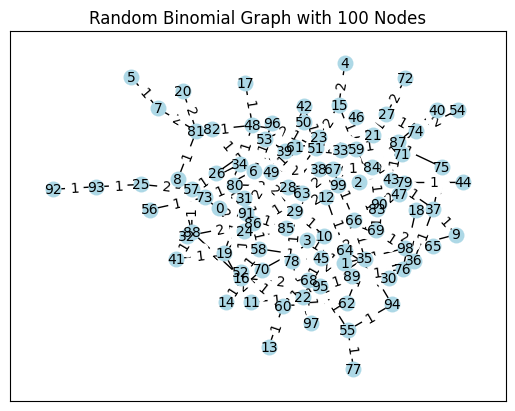

In [ ]:
import matplotlib.pyplot as plt # routine to plot the example graph
for line in nx.generate_adjlist(G3):
    print(line)

links = [(u, v) for (u, v, d) in G3.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G3)
nx.draw_networkx_nodes(G3, pos, node_size=130, node_color='lightblue', linewidths=0.05) # draw nodes
nx.draw_networkx_edges(G3, pos, edgelist=links, width=1)                               # draw edges

# node labels
nx.draw_networkx_labels(G3, pos, font_size=10, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G3, 'weight','trips')
print(edge_labels)
#print("%.2f" % edge_labels)
nx.draw_networkx_edge_labels(G3, pos, edge_labels)
plt.title("Random Binomial Graph with 100 Nodes")
plt.show()

In [ ]:
# Customer Class
class Customer:
  def __init__(self, customer_id):
    self.customer_id = customer_id
    self.pickup_node = random.randint(1,99)
    self.dropoff_node = random.randint(1,99)
    # Making sure that the pickup and dropoff nodes are different using {while loop}, until not different node
    while self.pickup_node == self.dropoff_node:
        self.dropoff_node = random.randint(1,99)

# Van Class
class Van:
  def __init__(self,van_id):
    self.van_id = van_id
    self.current_node = 1
    self.idle = True
    self.service_queue = []
    self.p_traversed_nodes = []
    self.inside_van_service_queue = []
    self.congested_node_flag = False
    self.customer_serviced = 0
    self.number_of_nodes_visited = 0

  def move_one_step(self,destination_node):
    # Using shortest path from networkx and avoid congested path
    path = nx.dijkstra_path(G3,self.current_node,destination_node, weight='weight')
    next_node = nx.shortest_path(G3, self.current_node, destination_node, weight='weight')[1]
    print("van{} route:{}".format(self.van_id,path))
    print("van{} next travel node:{}".format(self.van_id,next_node))
    return next_node

  def update_node(self,destination_node):
    if destination_node is None or not G3.has_node(destination_node):
        print(f"Error: Node {destination_node} not found in the graph.")
        return
    if self.current_node != destination_node:
        next_node = nx.shortest_path(G3, self.current_node, destination_node, weight='weight')[1] # checking next node
        # checking if we are forced to traverse a congested node
        if G3.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == False:
          self.congested_node_flag = True # set flag for congested node
          print("van{} is treaversing congested node:{}".format(self.van_id,next_node))
        elif G3.get_edge_data(self.current_node,next_node) == 2 and self.congested_node_flag == True:
          self.congested_node_flag == False # we've traveled one clock tick on congested node, setting flag to false
          self.current_node = self.move_one_step(destination_node)
          # keep note of number of nodes visited by this van
          self.number_of_nodes_visited += 1
        else:
          self.current_node = self.move_one_step(destination_node)
          self.number_of_nodes_visited += 1
    print(f"Van{self.van_id} moved to {self.current_node}")
    print("Van{} service queue:{}".format(self.van_id,self.service_queue))
    print("Van{} has {} passengers, their(id,pickup,dropoff):{}".format(self.van_id,len(self.inside_van_service_queue),self.inside_van_service_queue))


  def idle_status(self):
    if self.service_queue == []:
        self.idle = True
        print("Van{} is parked at {}".format(self.van_id, self.current_node))
    else:
        self.idle = False

  def dropoff_customer(self):
    if self.service_queue != []:
        # for drop off we use the inside van service list(customers in the van)
        for request in self.inside_van_service_queue:
            customer_id,_,dropoff_node = request
            # permisible pick up nodes along the route
            permisible_pickup_nodes = nx.dijkstra_path(G3,self.current_node,dropoff_node, weight='weight')[1:-2] # next node to before drop off
            # Dropping off customers at the dropoff node if their drop off node is same
            if self.current_node == dropoff_node:
                print(f"Van{self.van_id} dropped off customer {customer_id} at {dropoff_node}")
                # Remove the request from van's service queue and inside van service queue after dropoff
                self.service_queue = [service_request for service_request in self.service_queue if service_request[2] != dropoff_node]
                self.inside_van_service_queue = [service_request for service_request in self.inside_van_service_queue if service_request[2] != dropoff_node]
                self.customer_serviced += 1
                # we need to get rid off pick up node already traversed related to this drop off node
                del self.p_traversed_nodes[0]
                break
            elif self.current_node in permisible_pickup_nodes: # we'll pick up customers in service queue if they are along a drop off path
              for request in self.service_queue:
                if request[1] == self.current_node:
                  print("van{} picked up customer{} from: {}".format(self.van_id,request[0],self.current_node))
                  self.inside_van_service_queue.append(request) # add customers in inside service queue
                  self.update_node() # move van one node afer pick up
            else:
              self.update_node(dropoff_node)
              break

  def pickup_customer(self):
    if self.service_queue != []:
        for request in self.service_queue:
            customer_id,pickup_node,_ = request
            if self.current_node == pickup_node and len(self.inside_van_service_queue)<6:
                # Picking up customers at the pickup node if their pickup node is same
                print(f"Van{self.van_id} picked up customer {customer_id} from {pickup_node}")
                # updating passengers inside the van
                self.inside_van_service_queue.append(request)
                # We need to flag current pickup node as already traversed
                self.p_traversed_nodes.append(pickup_node)
                self.dropoff_customer()
                break
            elif self.current_node == pickup_node and len(self.inside_van_service_queue)==5:   # If van is full with 5 passengers
              print("van{} is full customer{} has to wait 15 mins!".format(self.van_id,customer_id))
              self.update_node(pickup_node)
              break
            elif pickup_node in self.p_traversed_nodes:
                self.dropoff_customer()
                break
            else:
              self.update_node(pickup_node)
              break

In [ ]:
def assign_request(customer_id,pickup_node,dropoff_node,vans):
    min_distance = float('inf')  # Giving min_distance an initial value of infinity to later assign smaller values
    selected_van = None

    for van in vans:
        # Get the shortest distance from the van's current node to the pickup node
        distance = nx.dijkstra_path(G3, van.current_node, pickup_node)

        # Select the van with the shortest distance or the lowest van_id in case of tie in distance from pickup node
        if float(len(distance)) < min_distance:
            min_distance = float(len(distance))
            selected_van = van
        elif float(len(distance)) == min_distance and van.van_id < selected_van.van_id:
            selected_van = van

    selected_van.service_queue.append((customer_id,pickup_node,dropoff_node))
    print(f"Assigned customer {customer_id} (Pickup: {pickup_node}, Dropoff: {dropoff_node}) to Van {selected_van.van_id}")

In [ ]:
import random
import time
from datetime import datetime, timedelta

# Service Start and End Times
service_start_time = datetime.strptime('08:00', '%H:%M')
service_end_time = datetime.strptime('18:00', '%H:%M')
current_time = service_start_time
clock_tick = timedelta(minutes=1)
clock_tick_counter = 1
stop_service = 0

customer_request_list = []  # This list will contain customer requests that will be generated at each clock tick
next_id = 1 # Next Customer ID


# We have 2 vans
vans = [Van(van_id=i) for i in range(1, 61)]

# Method to check if every van's service queue is empty
def every_van_ended_service(VansList):
  for every_van in VansList:
    if every_van.service_queue != []:
      return False
    else:
      return True

# Function to generate customer requests at each clock tick
def generate_customer_requests(customer_request_list,current_time,next_id):
    customer = Customer(next_id)
    customer_request_list.append(customer)  # Add customer request to the list
    print(f"New pick up request from customer {customer.customer_id} (Pickup: {customer.pickup_node}, Dropoff: {customer.dropoff_node}) at {current_time.strftime('%H:%M')}")
    return next_id + 1

# ---------------Simulation Starts Here--------------------

while stop_service<1:
  # Simulation loop from Service Start to End Time
  if current_time <= service_end_time:
      # Generate 450 to 600 customer requests per hour
      # Create a list of clock values that are multiples of 60 between 1 and 601(to generate 45 to 60 request per hour)
      clock_tick_values = list(range(1, 601, 3))
      # Select 10 random clock values from the list
      random_clock_tick_values = random.sample(clock_tick_values, 200)
      if clock_tick_counter in random_clock_tick_values:
        iteration_number = random.randint(20,30)
        for i in range(iteration_number):
          next_id = generate_customer_requests(customer_request_list,current_time,next_id)
      else:
        pass

  # Assign customer requests to vans
  for customer in customer_request_list:
      assign_request(customer.customer_id, customer.pickup_node,customer.dropoff_node,vans)
      # Once assigned remove the request from the customer request list
      customer_request_list.remove(customer)

  # If van has non empty service queue, it starts to work
  for van in vans:
    if van.service_queue != []:
      van.pickup_customer()
      # van.dropoff_customer() ----> we do not need to run this as our drop off is handeled by the pickup_customer()
      # print("Van {} Service Queue:{}".format(van.van_id,van.service_queue))
    elif every_van_ended_service(vans) and current_time > service_end_time:
      stop_service += 1
      break
    else:
      van.idle_status()

  print("\n") # space for next clock tick simulation
  print("===================================== Clock Tick:{}".format(clock_tick_counter)) # seperation for next clock tick simulation

  # Move time forward by 1 clock tick
  current_time += clock_tick
  clock_tick_counter += 1

# get the number of customer serviced the whole day
def service_calculation():
  total_count = 0
  total_visited_nodes = 0
  for van in vans:
    total_count += van.customer_serviced
    total_visited_nodes += van.number_of_nodes_visited
  return total_count, total_visited_nodes

total_service_count,visited_node_count = service_calculation()
print("\n")
print("Todal total customer service count was:{} persons.".format(total_service_count))
print("Average customer serviced per hour was:{} persons.".format(total_service_count//10))
print("Average customer waiting time was {} minutes.".format(visited_node_count/total_service_count))

Streaming output truncated to the last 5000 lines.
Van17 is parked at 2
Van18 is parked at 13
Van19 is parked at 28
Van20 is parked at 4
Van21 is parked at 37
Van22 is parked at 85
Van23 is parked at 65
Van24 is parked at 24
Van25 is parked at 72
Van26 is parked at 12
Van27 is parked at 72
Van28 is parked at 10
Van29 is parked at 45
Van30 is parked at 49
Van31 is parked at 68
Van32 is parked at 12
Van33 is parked at 21
Van34 is parked at 13
Van35 is parked at 10
Van36 is parked at 66
Van37 is parked at 73
Van38 is parked at 23
Van39 is parked at 29
Van40 is parked at 26
Van41 is parked at 83
Van42 is parked at 97
Van43 is parked at 97
Van44 is parked at 10
Van45 is parked at 30
Van46 is parked at 94
Van47 is parked at 86
Van48 is parked at 26
Van49 is parked at 32
Van50 is parked at 20
Van51 is parked at 99
Van52 is parked at 1
Van53 is parked at 50
Van54 is parked at 16
Van55 is parked at 91
Van56 is parked at 33
Van57 is parked at 24
Van58 is parked at 60
Van59 is parked at 16
Van60 

## R5 Answer
Todal total customer service count/number of trips were:3702 persons.<br>
Average customer serviced per hour was:30 persons.<br>
Average customer waiting time was 5.137223122636413 minutes.<br>

# We can see that this takes more time as connectivity is low compared to the graph used in R3 and R4. The taxis have to take longer route to reach their customer. Which is why we serviced less people as well.